# import packages

In [1]:
import sys
import os
import io
# os.environ["CUDA_VISIBLE_DEVICES"] = '1'
import gc
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import torch
from PIL import Image
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import recall_score, roc_auc_score
import sys
import timm
from timm import create_model, list_models
from timm.data import create_transform
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
import random
import wandb
from wandb import AlertLevel


import torchvision
from torch.utils.data import Dataset
from torch.nn import functional as F
from torch.nn import Module, Linear, Sequential, ModuleList, ReLU, Dropout, Flatten
from torch import nn
from torch.utils.data import DataLoader
from torch.optim import Adam, SGD, AdamW, lr_scheduler
import warnings
warnings.filterwarnings('ignore')


# os.environ['WANDB_API_KEY'] = 'YOUR KEY HERE' # I dont provide this, but I set it to offline.
gc.collect()
torch.cuda.empty_cache()

from utils import seed_everything, init_logger, get_timediff, optimal_f1, gc_collect, add_weight_decay, get_parameter_number
from model import GeM, BreastCancerModel
from dataset import BreastCancerDataSet_16bit, BreastCancerDataSet_8bit, mixup_augmentation, get_transforms_8bit, get_transforms_16bit

# CFG

In [2]:
class CFG:
    suff = "0001"
    image_size =  (1536, 896)
    epochs = 15
    model_arch = 'tf_efficientnet_b4'
    dropout = 0.0
    fc_dropout=0.2
    es_paitient = 3

    onecycle = True
    onecycle_pct_start = 0.1
    max_lr = 1e-4
    optim = "AdamW"
    weight_decay = 0.01
    accum_iter=1

    positive_target_weight = 1
    neg_downsample = 0.35
    train_batch_size = 16
    valid_batch_size = 16
    mixup_rate = 0.5
    mixup_alpha = 0.5

    tta = True
    
    seed = 1788
    num_workers = 5
    n_folds = 5
    folds = [0]
    gpu_parallel = False
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    df_path = f'/blue/eel6825/f.yang1/kaggle/'

    normalize_mean= [0.485, 0.456, 0.406]  # [0.21596, 0.21596, 0.21596]
    normalize_std = [0.229, 0.224, 0.225]  # [0.18558, 0.18558, 0.18558]

    wandb_project = f'RSNA2023-V5' 
    wandb_run_name = f'{suff}_{model_arch}'

    target = 'cancer'


comp_data_dir = '/blue/eel6825/f.yang1/kaggle/'
images_dir = f'/blue/eel6825/f.yang1/kaggle/train_images/'
output_dir = f'/blue/eel6825/f.yang1/{CFG.suff}'
os.makedirs(output_dir, exist_ok=True)

DEBUG = True
WANDB_SWEEP = False
TRAIN = True
CV = True

In [3]:
seed_everything(CFG.seed)

LOGGER = init_logger(f'{output_dir}/train_{CFG.suff}.log')

In [4]:
LOGGER.info(f'run: {CFG.wandb_run_name}; folds:{CFG.folds}')
LOGGER.info(f"timm.version: {timm.__version__}")

# try:
#     df_train = pd.read_csv(CFG.df_path)
# except:
LOGGER.info(f"Can't find {CFG.df_path}, creating one")
df_train = pd.read_csv(f'{comp_data_dir}/train.csv')
split = StratifiedGroupKFold(CFG.n_folds)
for k, (_, test_idx) in enumerate(split.split(df_train, df_train.cancer, groups=df_train.patient_id)):
    df_train.loc[test_idx, 'split'] = k
df_train.split = df_train.split.astype(int)
df_train["sample_rand"] = np.random.rand(len(df_train)) 
df_train.loc[df_train["cancer"]==1, "sample_rand"] = 0.0
df_train.to_csv(f'./df_train_{CFG.suff}.csv', index=False)

df_train = df_train[df_train['image_id'].astype(str) != '1942326353'].reset_index(drop=True)
df_train = df_train[df_train['patient_id'].astype(str) != '27770'].reset_index(drop=True)

run: 0001_tf_efficientnet_b4; folds:[0]
timm.version: 0.6.13
Can't find /blue/eel6825/f.yang1/kaggle/, creating one


# dataset class

X.shape: torch.Size([3, 1536, 896]), y_cancer.shape: torch.Size([])


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b4_aa-818f208c.pth" to /home/f.yang1/.cache/torch/hub/checkpoints/tf_efficientnet_b4_aa-818f208c.pth
Total params: 17.6M; Trainable params: 17.0M


model output: torch.Size([2])


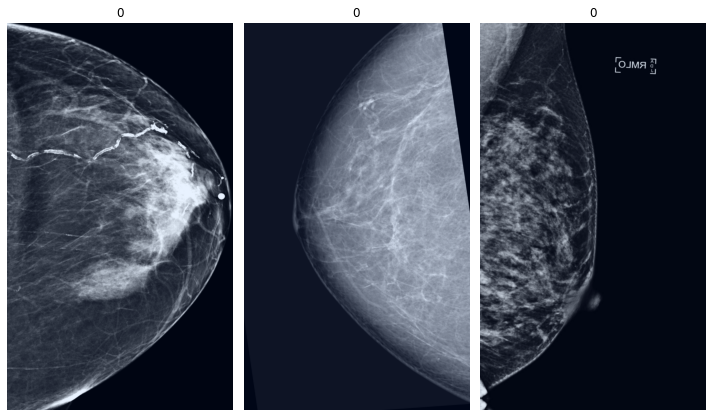

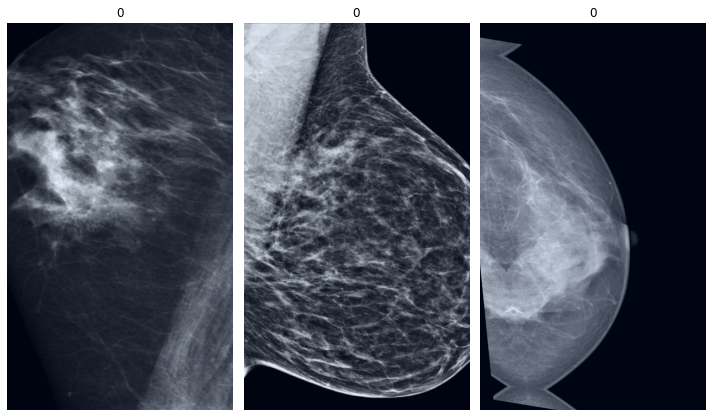

In [5]:
if DEBUG:
    ds_train = BreastCancerDataSet_8bit(df_train, images_dir, CFG.target, get_transforms_8bit('train', CFG.image_size, CFG.normalize_mean, CFG.normalize_std))
    X, y_cancer = ds_train[42]
    print(f"X.shape: {X.shape}, y_cancer.shape: {y_cancer.shape}")


dataset_show = BreastCancerDataSet_8bit(df_train, images_dir, CFG.target, get_transforms_8bit('train', CFG.image_size, CFG.normalize_mean, CFG.normalize_std))
for i in range(2):
    f, axarr = plt.subplots(1,3, figsize=(10,8))
    for p in range(0,3):
        idx = np.random.randint(0, len(dataset_show))
        img, cancer_target = dataset_show[idx]
        img = ((img-img.min())/(img.max()-img.min())*255).to(torch.uint8).transpose(0, 1).transpose(1,2)
        axarr[p].imshow(img)
        axarr[p].set_title(str(cancer_target.item()))
        axarr[p].axis('off')
        plt.tight_layout()
    plt.savefig(f'{output_dir}/show_{i}.jpg')
    # plt.show()


# 3. Model
if DEBUG:
    with torch.no_grad():
        model = BreastCancerModel(model_arch=CFG.model_arch, dropout=0.0, fc_dropout=0.0)
        pred = model(torch.randn(2, 3, 512, 512))
        print('model output:', pred.shape)
        LOGGER.info(get_parameter_number(model))
    del model

# train and test

In [6]:
def valid_one_epoch(model, dataloader):
    model = model.to(CFG.device)
    cancer_pred_list = []
    with torch.no_grad():
        model.eval()
        losses = []; targets = []
        with tqdm(dataloader, desc='Eval', mininterval=30) as progress:
            for i, (X, y_c) in enumerate(progress):
                with autocast(enabled=True):
                    X = X.to(CFG.device)
                    y_c = y_c.to(float).to(CFG.device)
                    
                    pred_c = model(X).view(-1)
                    if CFG.tta:
                        pred_c2 = model(torch.flip(X, dims=[-1])) # horizontal mirror
                        pred_c = (pred_c + pred_c2) / 2

                    loss = F.binary_cross_entropy_with_logits(pred_c, y_c, pos_weight=torch.tensor([CFG.positive_target_weight]).to(CFG.device)).item()
                    loss = loss / CFG.accum_iter
                    
                    cancer_pred_list.append(torch.sigmoid(pred_c))
                    losses.append(loss); targets.append(y_c.cpu().numpy())
        
        targets = np.concatenate(targets)
        pred = torch.concat(cancer_pred_list).cpu().numpy()
        pf1, thres = optimal_f1(targets, pred)
        
        # Compute recall and AUC
        recall = recall_score(targets, (pred > thres).astype(int))
        auc = roc_auc_score(targets, pred)
        
        #      (best_pf1, best_thres)  pred_value  mean_all_losses  recall  auc
        return (pf1,      thres),      pred,       np.mean(losses), recall, auc

In [7]:
def train_one_epoch(model, dl, optim, scheduler, cancer_criterion, epoch, logger):
    model.train()
    scaler = GradScaler()
    losses = []
    with tqdm(dl, desc='Train', mininterval=10) as train_progress:
        for batch_idx, (img, yc) in enumerate(train_progress):
            img = img.to(CFG.device)
            yc = yc.to(float).to(CFG.device)
            
            # Mixup- allowed
            if torch.randn(1)[0] < CFG.mixup_rate and img.shape[0]>1:  
                mixed_x, yc_j, yc_k, lam = mixup_augmentation(img, yc, alpha=CFG.mixup_alpha)
                with autocast(enabled=True):
                    pred_c = model(mixed_x).view(-1) 
                    # Mixup loss calculation
                    loss_j = cancer_criterion(pred_c, yc_j, pos_weight=torch.tensor([CFG.positive_target_weight]).to(CFG.device)) 
                    loss_k = cancer_criterion(pred_c, yc_k, pos_weight=torch.tensor([CFG.positive_target_weight]).to(CFG.device))
                    loss = lam * loss_j + (1 - lam) * loss_k
        
            # Mixup - not allowed
            else:
                if img.shape[0] <= 1:
                    print('batch size is 1, skipping mixup') 
                with autocast(enabled=True):
                    pred_c = model(img).view(-1) 
                    loss = cancer_criterion(pred_c, yc, pos_weight=torch.tensor([CFG.positive_target_weight]).to(CFG.device)) 

            if np.isinf(loss.item()) or np.isnan(loss.item()):
                print(f'Bad loss, skipping the batch {batch_idx}')
                del loss, pred_c
                gc_collect()
                continue
            loss = loss / CFG.accum_iter
            losses.append(loss.item())
            scaler.scale(loss).backward() # scaler is needed to prevent "gradient underflow"
            if (batch_idx + 1) % CFG.accum_iter == 0:
                scaler.step(optim)
                scaler.update()
                optim.zero_grad()

            if scheduler is not None:
                scheduler.step()
            
            logger.log({'tr_loss': (loss.item()),
                        'lr': scheduler.get_last_lr()[0] if scheduler else CFG.max_lr,
                        'epoch': epoch})
            
    return model, np.mean(losses[-30:])

In [8]:
def train_loop(logger, fold, do_save_model=True):
    # ====================================================
    # data loader
    # ====================================================
    tr_df = df_train.query('split != @fold')
    tr_df = tr_df[tr_df["sample_rand"] <= CFG.neg_downsample].reset_index(drop=True)
    va_df = df_train.query('split == @fold')
    LOGGER.info(f"train: {len(tr_df)}, train pos rate: {tr_df['cancer'].mean():.3f}")
    LOGGER.info(f"valid: {len(va_df)}, valid pos rate: {va_df['cancer'].mean():.3f}")

    ds_train = BreastCancerDataSet_8bit(tr_df, images_dir, CFG.target, get_transforms_8bit('train', CFG.image_size, CFG.normalize_mean, CFG.normalize_std))
    ds_valid = BreastCancerDataSet_8bit(va_df, images_dir, CFG.target, get_transforms_8bit('valid', CFG.image_size, CFG.normalize_mean, CFG.normalize_std))
    dl_train = DataLoader(ds_train, batch_size=CFG.train_batch_size, shuffle=True,  num_workers=CFG.num_workers, pin_memory=True,  drop_last=True)
    dl_valid = DataLoader(ds_valid, batch_size=CFG.valid_batch_size, shuffle=False, num_workers=CFG.num_workers, pin_memory=False, drop_last=False)
    
    # ====================================================
    # model & optimizer & scheduler & loss
    # ====================================================
    # model
    model = BreastCancerModel(CFG.model_arch, CFG.dropout, CFG.fc_dropout).to(CFG.device)
    if CFG.gpu_parallel:    
        from torch.nn import DataParallel
        num_gpu = torch.cuda.device_count()
        model = DataParallel(model, device_ids=range(num_gpu))
        LOGGER.info(f"enable gpu parallel, num_gpu: {num_gpu}")
    
    # optimizer
    if CFG.optim == "AdamW":
        optim = AdamW(add_weight_decay(model, weight_decay=CFG.weight_decay, skip_list=['bias']), lr=CFG.max_lr, betas=(0.9, 0.999), weight_decay=CFG.weight_decay)
    elif CFG.optim == "Adam":
        optim = Adam(model.parameters())
    
    # scheduler
    scheduler = None
    if CFG.onecycle:
        scheduler = lr_scheduler.OneCycleLR(optim, max_lr=CFG.max_lr, epochs=CFG.epochs, steps_per_epoch=len(dl_train), pct_start=CFG.onecycle_pct_start)
    
    # loss
    cancer_criterion = F.binary_cross_entropy_with_logits

    # ====================================================
    # loop
    # ====================================================    
    best_valid_score = 0; best_valid_thres=0
    n_es = 0
    for epoch in range(CFG.epochs):
        model, tr_loss = train_one_epoch(model, dl_train, optim, scheduler, cancer_criterion, epoch, logger)
        (f1, thres), _, va_loss, recall, auc = valid_one_epoch(model, dl_valid)

        n_es += 1
        if f1 > best_valid_score:
            n_es = 0
            best_valid_score = f1
            best_valid_thres = thres
            if do_save_model and epoch > 3:
                save_name = f'{output_dir}/{CFG.suff}_f{CFG.model_arch}_f{fold}_ep{epoch}.pth'
                torch.save({'model': model.state_dict(), 'threshold': thres, 'model_arch': CFG.model_arch}, save_name)
                best_dict[fold] = save_name

        LOGGER.info(f'Epoch {epoch} - valid_f1: {f1:.4f} - valid_thres: {thres:.4f} - best_f1: {best_valid_score:.4f} - best_thres: {best_valid_thres:.4f}, lr: {scheduler.get_last_lr()[0] if scheduler else CFG.max_lr}')
        LOGGER.info(f"train_loss: {tr_loss:.4f} - valid_loss: {va_loss:.4f}")
        LOGGER.info(f"recall: {recall:.4f} - auc: {auc:.4f}")
        logger.log({
            'fold':       fold,
            'epoch':      epoch,
            'va_loss':    va_loss,
            'va_pf1':     f1,
            'va_thres':   thres,
            'best_pf1':   best_valid_score,
            'best_thres': best_valid_thres,
            })

        if n_es > CFG.es_paitient:
            LOGGER.info(f'Early Stopping - Epoch: {epoch}')
            break

In [9]:
if TRAIN:
    best_dict = {}
    for fold in CFG.folds:
        LOGGER.info(f'\n========== Fold {fold} ==========')
        with wandb.init(project=CFG.wandb_project, name=f'{CFG.wandb_run_name}-f{fold}', group=CFG.wandb_run_name,mode="offline") as run:
            gc_collect()
            train_loop(run, fold)

try:
    with open(f"{output_dir}/finished","w") as f:
        f.write("finish")
except:
    LOGGER.info("write finished fail.")


========== Fold 0 ==========
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train: 15893, train pos rate: 0.058
valid: 10929, valid pos rate: 0.021
Eval: 100%|██████████| 684/684 [05:16<00:00,  2.16it/s]
Epoch 0 - valid_f1: 0.0763 - valid_thres: 0.1200 - best_f1: 0.0763 - best_thres: 0.1200, lr: 7.605846622621303e-05
train_loss: 0.2391 - valid_loss: 0.1189
recall: 0.1299 - auc: 0.6455
Eval: 100%|██████████| 684/684 [05:17<00:00,  2.16it/s]
Epoch 1 - valid_f1: 0.1929 - valid_thres: 0.2100 - best_f1: 0.1929 - best_thres: 0.2100, lr: 9.966055755649275e-05
train_loss: 0.1986 - valid_loss: 0.1088
recall: 0.2468 - auc: 0.7630
Eval: 100%|██████████| 684/684 [05:16<00:00,  2.16it/s]
Epoch 2 - valid_f1: 0.3025 - valid_thres: 0.2000 - best_f1: 0.3025 - best_thres: 0.2000, lr: 9.698063418809367e-05
train_loss: 0.2634 - valid_loss: 0.0998
recall: 0.2900 - auc: 0.7681
Eval: 100%|██████████| 684/684 [05:17<00:00,  2.16it/s]
Epoch 3 - valid_f1: 0.3019 - valid_thres: 0.2300 - best_f1: 0.3025 - best_thres: 0.2000, lr: 9.176798345218232e-05
train_loss: 0.1911 - valid_loss: 0.09

best_pf1,▁▄▇▇███████████
best_thres,▁▂▂▂▇▇████▄▄▅▅▅
epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
fold,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,▁▂▅▇██████▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
tr_loss,▃▂▂▆▄▅▅▅▂▃▆▂▆▆▂▂▅▇▅▁▄▆▃▂█▃▅▁▁▁▃▂▄▂▂▁▂▂▃▄
va_loss,█▆▄▂▇▁▃▁▅▂▃▃▃▃▃
va_pf1,▁▄▇▇█▇█▇▇██▇███
va_thres,▁▂▂▂▆▄▆▃█▄▄▄▄▄▆
best_pf1,0.358
best_thres,0.42


In [10]:

def gen_predictions(models, df_train, folds):
    df_train_predictions = []
    for model, fold in zip(models, folds):
        ds_valid = BreastCancerDataSet_8bit(df_train.query('split == @fold'), images_dir, CFG.target, get_transforms_8bit('valid', CFG.image_size, CFG.normalize_mean, CFG.normalize_std))
        valid_dataloader  = DataLoader(ds_valid, batch_size=CFG.valid_batch_size, shuffle=False, num_workers=CFG.num_workers, pin_memory=False)
        (pf1, thres), pred_cancer = valid_one_epoch(model, valid_dataloader)[:2]
        LOGGER.info(f'Eval fold:{fold} pF1:{pf1:.03f} thres:{thres:.02f}')
        
        df_pred = pd.DataFrame(data=pred_cancer, columns=['cancer_pred_proba'])
        df_pred['cancer_pred'] = df_pred["cancer_pred_proba"] > thres
        

        df = pd.concat(
            [df_train.query('split == @fold').reset_index(drop=True), df_pred],
            axis=1
        ).sort_values(['patient_id', 'image_id'])
        df_train_predictions.append(df)
    df_train_predictions = pd.concat(df_train_predictions)
    return df_train_predictions


if CV:
    def load_model(path, model=None):
        state_dict = torch.load(path, map_location=CFG.device)
        if model is None:
            model = BreastCancerModel(state_dict['model_arch'], CFG.dropout, CFG.fc_dropout)
        model.load_state_dict(state_dict['model'])
        return model, state_dict['threshold'], state_dict['model_arch']

    models = [load_model(best_dict[fold])[0] for fold in CFG.folds]
    df_pred = gen_predictions(models, df_train, CFG.folds)
    df_pred.to_csv(f'{output_dir}/train_predictions.csv', index=False)
    # display(df_pred.head())

    LOGGER.info(f'F1 CV score (multiple thresholds): {sklearn.metrics.f1_score(df_pred["cancer"], df_pred["cancer_pred"])}')    

    df_pred_all = df_pred.groupby(['patient_id', 'laterality']).agg(
        cancer_max=('cancer_pred_proba', 'max'), cancer_mean=('cancer_pred_proba', 'mean'), cancer=('cancer', 'max')
    )
    LOGGER.info(f'ALL pF1 CV score. Mean , single threshold: {optimal_f1(df_pred_all["cancer"].values, df_pred_all["cancer_mean"].values)}', )
    LOGGER.info(f'ALL pF1 CV score. Max  , single threshold: {optimal_f1(df_pred_all["cancer"].values, df_pred_all["cancer_max"].values)}', )

    df_pred1 = df_pred[df_pred["site_id"]==1].groupby(['patient_id', 'laterality']).agg(
        cancer_max=('cancer_pred_proba', 'max'), cancer_mean=('cancer_pred_proba', 'mean'), cancer=('cancer', 'max')
    )
    LOGGER.info(f'SITE1 pF1 CV score. Mean , single threshold: {optimal_f1(df_pred1["cancer"].values, df_pred1["cancer_mean"].values)}', )
    LOGGER.info(f'SITE1 pF1 CV score. Max  , single threshold: {optimal_f1(df_pred1["cancer"].values, df_pred1["cancer_max"].values)}', )

    df_pred2 = df_pred[df_pred["site_id"]==2].groupby(['patient_id', 'laterality']).agg(
        cancer_max=('cancer_pred_proba', 'max'), cancer_mean=('cancer_pred_proba', 'mean'), cancer=('cancer', 'max')
    )
    LOGGER.info(f'SITE2 pF1 CV score. Mean , single threshold: {optimal_f1(df_pred2["cancer"].values, df_pred2["cancer_mean"].values)}', )
    LOGGER.info(f'SITE2 pF1 CV score. Max  , single threshold: {optimal_f1(df_pred2["cancer"].values, df_pred2["cancer_max"].values)}', )


Eval: 100%|██████████| 684/684 [05:14<00:00,  2.18it/s]
Eval fold:0 pF1:0.358 thres:0.42
F1 CV score (multiple thresholds): 0.35799522673031026
ALL pF1 CV score. Mean , single threshold: (0.4225352112676056, 0.48)
ALL pF1 CV score. Max  , single threshold: (0.425, 0.79)
SITE1 pF1 CV score. Mean , single threshold: (0.3380281690140845, 0.48)
SITE1 pF1 CV score. Max  , single threshold: (0.35714285714285715, 0.8200000000000001)
SITE2 pF1 CV score. Mean , single threshold: (0.5185185185185185, 0.35000000000000003)
SITE2 pF1 CV score. Max  , single threshold: (0.5135135135135135, 0.78)
